<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/Emails_Processing_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Email Analysis Notebook



*   Word Embeddings are used for the email text analysis
*   TSNE and Enbedding Projector are used for data visual analysis of the data
*   LDA - Latent Dirichle Allocation is used for the Topic Modelling
*   K-means is used for clustering (embeddings base) <br>

*Findings*


*   There is no clear clustering for the date
*   There is a significant differences in groupings based on the LDA topics vs K-means (based on PCA embedding transform)
*   Embeddings Projector is cool :)













# Email Parsing & Initial Processing

In [23]:
#Imports
import pandas as pd
import numpy as np
import re
import io
from pathlib import Path

In [62]:
!rm -rf all_documents

In [63]:
# file upload while using Google Colab
from google.colab import files
uploaded = files.upload()

Saving all_documents.zip to all_documents.zip


In [ ]:
# files unzipping
!unzip all_documents.zip

In [ ]:
with open('./contacts/1462.copy', 'r',encoding='utf-8-sig') as file:
    data = file.read()

In [199]:
#paths = Path('/content/contacts').glob('**/[!.]*')
paths = Path('/content/all_documents').glob('**/[!.]*')
msg = []
file_path = []

#For whatever reason this is the only way Pathlib works with CoLab, sad... 
for path in paths:
    path_in_str = str(path)
    file_path.append(path_in_str)
for item in file_path:    
    with io.open(item, 'r', errors='ignore') as file:
      msg.append(file.read())

In [67]:
#message processing
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            if not re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", line) and \
            not re.findall(r"(\.com|\.org|IMAP|ESMTP|(EDT)|(ICT))", line): 
              message += line.strip()
              email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val+' ' # to make combined labels readable
    return email

def parse_into_emails(messages):
  emails = [parse_raw_message(message) for message in messages]
  return {'body': map_to_list(emails, 'body'), 
          'to': map_to_list(emails, 'to'), 
          'from': map_to_list(emails, 'from')
          }

def map_to_list(dct, key):
  tmp = []
  for item in dct:
    try:
      tmp.append(item[key])
    except Exception:
      tmp.append('empty_field')  
  return tmp 

In [203]:
#test
res = parse_into_emails(msg)
# lst of labels for the Embedding Projector
labels = [str(x)+str(y) for x,y in zip(res['from'], res['to'])] # str()  is just to make sure bcs the data is pretty dirty

In [69]:
#text processing
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [204]:
#dealing with punctions while preventing word merging the words(people don't put blanks where they should...)
tmp = []
for item in res['body']:
  temp = item.translate(str.maketrans(',.', '  '))
  tmp.append(temp.translate(str.maketrans('', '', string.punctuation)))
res['body'] = tmp  

# Modelling & Analysis

**Clustering - Visual Analysis**

In [72]:
!pip install -q tensorflow-hub
import tensorflow_hub as hub

In [37]:
# data visualization:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [38]:
#using universal sentence encoder to get sentence encodings
#Load the Universal Sentence Encoder's TF Hub module
#param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" # Using DAN
print ("module {} loaded".format(module_url))
model = hub.load(module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [209]:
embedding_tuples = []
for item, label in zip(res['body'], labels):
  tmp = embed([item])[0].numpy(),label
  embedding_tuples.append(tmp)

In [247]:
# visualization code
def tsne_plot(emb):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for i in range(len(emb)):
        tokens.append(emb[i][0])
        labels.append(emb[i][1])
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    print(f'number of points - {len(x)}')

    plt.figure(figsize=(16, 16)) 

    for i in range(len(x)):
        plt.scatter(x[i],y[i])
    plt.show()
    return x,y

number of points - 834
number of points - 834


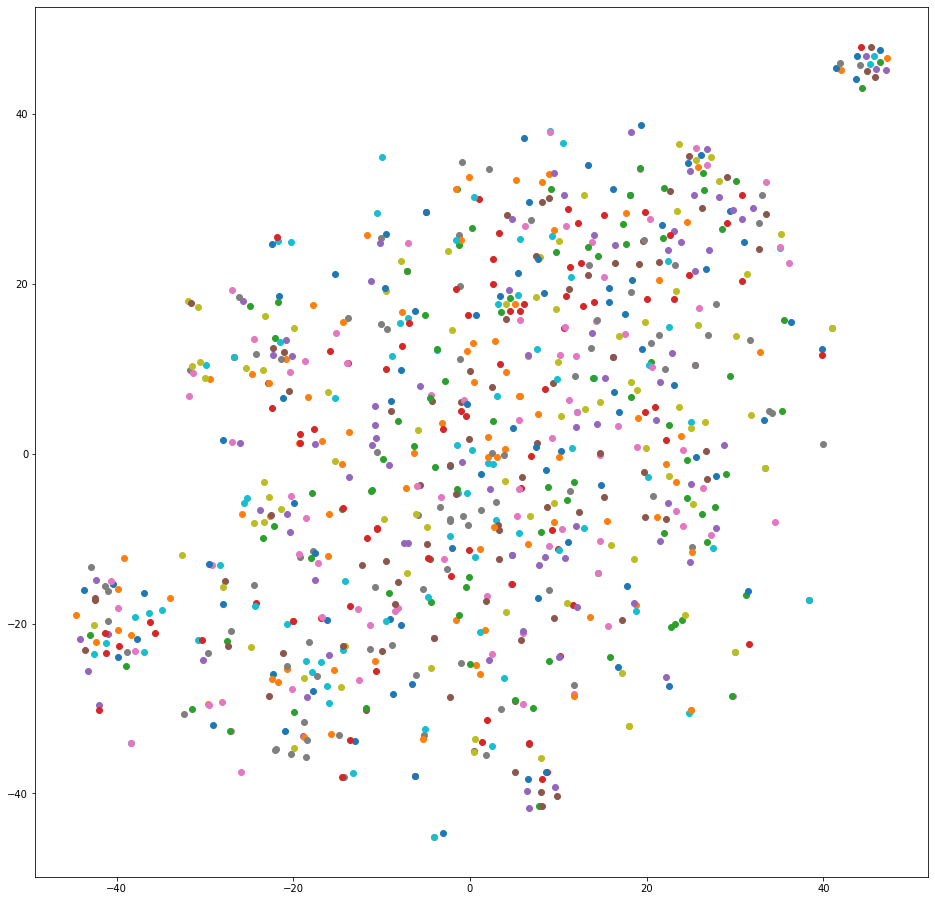

In [248]:
# The goal here is to see whether the data has any structure whatever
dim_x, dim_y = tsne_plot(embedding_tuples)

**Tensorflow Embedding Projector**

In [50]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
%load_ext tensorboard

In [51]:
import os
from tensorboard.plugins import projector
import tensorflow as tf

In [92]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='/logs/emb/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately line-by-line
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for label in embedding_tuples:
    f.write("{}\n".format(label[1]))

# Save embeddings in tsv file.

with open(os.path.join(log_dir, 'vectors.tsv'), "w") as f:
  for vec in embedding_tuples:
    tmp = '\t'.join(str(x) for x in vec[0])
    f.write("{}\n".format(tmp))

In [93]:
# all embeddings as numpy array of shape [n_words, embedding_size]
arrays = [vec[0] for vec in embedding_tuples]
embeddings_vectors = np.stack(arrays, axis=0)

In [94]:
# Save embeddings in TF variable.
emb = tf.Variable(embeddings_vectors, name='word_embeddings')

# Add ops to save and restore all the variables.
checkpoint = tf.train.Checkpoint(embedding=emb)

In [95]:
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

'/logs/emb/embedding.ckpt-1'

In [96]:
# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [60]:
!kill 285

/bin/bash: line 0: kill: (285) - No such process


In [ ]:
%tensorboard --logdir /logs/emb/
#Don't forget to select PROJECTOR from the TensorBoard dropdown

**LDA - Latent Dirichle Allocation**<br>*Let's find out which topics emails are getting classified into*

In [212]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

In [213]:
#exlude stop words
stop_words = stopwords.words('english')
msgs_for_lde = [] 
for item in res['body']:
  tmp = [w for w in item.split() if w not in stop_words]
  msgs_for_lde.append(tmp)

In [214]:
#Lemmatizing
lemmatized = []
for item in msgs_for_lde:
  tmp = [wordnet_lemmatizer.lemmatize(w) for w in item]
  lemmatized.append(tmp)

In [215]:
dictionary = gensim.corpora.Dictionary(lemmatized)
bow_corpus = [dictionary.doc2bow(doc) for doc in lemmatized]

In [ ]:
#preview - for testing only
for i in range(len(bow_corpus[1])):
  print("Word {} (\"{}\") appears {} time.".format(bow_corpus[1][i][0],dictionary[bow_corpus[1][i][0]],bow_corpus[1][i][1]))

In [216]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=10, workers=2)

In [217]:
#getting a List of topics
for idx, topic in lda_model.print_topics():
  print(f'Topic: {idx} \n Top 10 Topics Words & Probabilities {topic}')

Topic: 0 
 Top 10 Topics Words & Probabilities 0.018*"I" + 0.006*"Enron" + 0.005*"Jeff" + 0.004*"would" + 0.004*"The" + 0.004*"know" + 0.003*"We" + 0.003*"like" + 0.003*"If" + 0.003*"time"
Topic: 1 
 Top 10 Topics Words & Probabilities 0.013*"Jeff" + 0.013*"I" + 0.006*"time" + 0.005*"company" + 0.005*"Enron" + 0.005*"Transactions" + 0.004*"Notional" + 0.004*"forward" + 0.004*"Value" + 0.004*"1"
Topic: 2 
 Top 10 Topics Words & Probabilities 0.004*"I" + 0.004*"The" + 0.003*"Houston" + 0.003*"SMU" + 0.003*"In" + 0.003*"member" + 0.003*"Enron" + 0.002*"Energy" + 0.002*"u" + 0.002*"A"
Topic: 3 
 Top 10 Topics Words & Probabilities 0.028*"I" + 0.005*"Mark" + 0.004*"The" + 0.004*"get" + 0.004*"one" + 0.003*"see" + 0.003*"time" + 0.003*"know" + 0.003*"thing" + 0.003*"think"
Topic: 4 
 Top 10 Topics Words & Probabilities 0.011*"Enron" + 0.009*"Chairman" + 0.007*"I" + 0.004*"Executive" + 0.004*"Chief" + 0.004*"business" + 0.004*"market" + 0.004*"CEO" + 0.004*"new" + 0.003*"also"
Topic: 5 
 Top 

In [218]:
topic_dict = {}
for item in bow_corpus:
  topic_id, prob = sorted(lda_model[item], key=lambda tup: -1*tup[1])[0]
  #print(f'topic id - {topic_id}, probability of being in the topic - {prob}')
  if topic_id not in topic_dict.keys():
    topic_dict[topic_id] = 1
  else:
    topic_dict[topic_id] +=1     
  topic_words =re.findall(r'\"(.+?)\"',lda_model.print_topic(topic_id, 5))
  #print(f'Top 5 words in topic - {topic_words}')

In [219]:
#Split words into the topics
for key, val in topic_dict.items():
  print(f'Topic ID - {key} -- Number of Docs in Topic - {val}')

Topic ID - 1 -- Number of Docs in Topic - 146
Topic ID - 5 -- Number of Docs in Topic - 164
Topic ID - 4 -- Number of Docs in Topic - 47
Topic ID - 8 -- Number of Docs in Topic - 134
Topic ID - 7 -- Number of Docs in Topic - 64
Topic ID - 3 -- Number of Docs in Topic - 68
Topic ID - 0 -- Number of Docs in Topic - 95
Topic ID - 9 -- Number of Docs in Topic - 29
Topic ID - 2 -- Number of Docs in Topic - 35
Topic ID - 6 -- Number of Docs in Topic - 52


**K clustering**

In [184]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer

In [225]:
#TF-IDF Calculation
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(res['body'])

In [226]:
X.shape

(834, 23355)

In [154]:
X = [list(x[0]) for x in embedding_tuples]

In [221]:
X = [list(x[0]) for x in embedding_tuples]
X = np.array(X)
pca = PCA(n_components=2)
coords = pca.fit_transform(X)

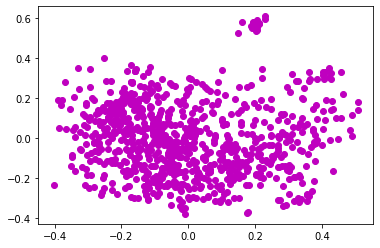

In [242]:
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [237]:
# no elbow method is used, mostly because it is clear that the data doesn't have much of a structure is so it is mostly to compare results to LDA
n_clusters = 10 
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(list(zip(dim_x,dim_y)))

In [244]:
clust_dict = {}
for cluster in labels:
  if cluster not in clust_dict.keys():
    clust_dict[cluster] = 1
  else:
    clust_dict[cluster] += 1

**Comparing the grouping by DLA and K-Clustering**

In [250]:
k_means_tuples = []
for key, value in clust_dict.items():
  k_means_tuples.append((value, key))

In [253]:
print(sorted(k_means_tuples))

[(22, 3), (59, 9), (68, 0), (69, 2), (83, 8), (95, 4), (106, 1), (107, 5), (108, 6), (117, 7)]


In [254]:
DLA_tuples = []
for key, value in topic_dict.items():
  DLA_tuples.append((value, key))

In [255]:
print(sorted(DLA_tuples))

[(29, 9), (35, 2), (47, 4), (52, 6), (64, 7), (68, 3), (95, 0), (134, 8), (146, 1), (164, 5)]
